In [1]:
import numpy as np
import gym
from collections import deque
import random
import torch.autograd
import os
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import sys
import pickle
import matplotlib.pyplot as plt
import pybullet as p 
import mujoco_py
import pybullet 
import pybullet_envs.gym_pendulum_envs 
import pybullet_envs.gym_locomotion_envs
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [2]:
# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


# https://github.com/openai/gym/blob/master/gym/core.py
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)
        

class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

In [3]:
class Critic(nn.Module):
    def __init__(self, input_size, output_size):
        super(Critic, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
                        
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            
            nn.Linear(32, output_size),
        )

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)

        return self.layers(x)

class Actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
                        
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            
            nn.Linear(32, output_size),
            nn.Tanh()
        )
        
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        return self.layers(state)

In [6]:
class DDPGagent:
    def __init__(self, env, hidden_size=[32, 64, 128, 64, 32], actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=int(1e5)):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks

        self.actor = Actor(self.num_states, self.num_actions).to(device)
        self.actor_target = Actor(self.num_states, self.num_actions).to(device)
        self.critic = Critic(self.num_states + self.num_actions, self.num_actions).to(device)
        self.critic_target = Critic(self.num_states + self.num_actions, self.num_actions).to(device)
        
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
        self.actor_lr_scheduler = optim.lr_scheduler.StepLR(self.actor_optimizer, step_size=100, gamma=0.8)
        self.critic_lr_scheduler = optim.lr_scheduler.StepLR(self.actor_optimizer, step_size=100, gamma=0.8)

    def get_action(self, state):
        state = torch.from_numpy(state).float().to(device)
        action = self.actor.forward(state)
        return action.cpu().detach().numpy()
    
    def get_latest_lr(self):
        return self.critic_lr_scheduler.get_last_lr()
    
    def update_lr(self):
        self.critic_lr_scheduler.step()
        self.actor_lr_scheduler.step()
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()
        
        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
            
    def save_agent_networks(self, prefix):
        torch.save(self.actor, prefix + '-actor.pt')
        torch.save(self.critic, prefix + '-critic.pt')
        
    def load_agent_networks(self, prefix):
        self.actor = torch.load(prefix + '-actor.pt').to(device)
        self.critic = torch.load(prefix + '-critic.pt').to(device)
        self.actor_target = self.actor
        self.critic_target = self.critic
        

In [ ]:
env = gym.make('InvertedDoublePendulumBulletEnv-v0')
agent = DDPGagent(env, gamma=0.9999)
noise = OUNoise(env.action_space)
batch_size = 4096
rewards = []
avg_rewards = []
learningRates = []
episodeLengths = []
for episode in range(1000):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    step = 0
    done = False
    
    while not done:
        action = agent.get_action(state)
#         action = noise.get_action(action, step)
        new_state, reward, done, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)
        
        state = new_state
        episode_reward += reward
        step += 1
        
    print("episode: {} || reward for episode: {} || average reward: {} || episode length: {}\n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-25:]), step))
    
    episodeLengths.append(step)
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-25:]))
    learningRates.append(agent.get_latest_lr())
    agent.update_lr()



episode: 0 || reward for episode: 426.85 || average reward: nan || episode length: 46

episode: 1 || reward for episode: 408.82 || average reward: 426.8455006215372 || episode length: 44

episode: 2 || reward for episode: 474.72 || average reward: 417.8319392997806 || episode length: 51

episode: 3 || reward for episode: 511.03 || average reward: 436.7943172669625 || episode length: 55

episode: 4 || reward for episode: 278.52 || average reward: 455.35267702897374 || episode length: 30

episode: 5 || reward for episode: 465.37 || average reward: 419.98680780753267 || episode length: 50

episode: 6 || reward for episode: 315.35 || average reward: 427.5500254355921 || episode length: 34

episode: 7 || reward for episode: 278.27 || average reward: 411.52104989830326 || episode length: 30

episode: 8 || reward for episode: 268.98 || average reward: 394.86406459571754 || episode length: 29

episode: 9 || reward for episode: 352.81 || average reward: 380.8769316503454 || episode length: 38



episode: 86 || reward for episode: 409.07 || average reward: 350.53863557935875 || episode length: 44

episode: 87 || reward for episode: 353.35 || average reward: 356.1449692339879 || episode length: 38

episode: 88 || reward for episode: 473.28 || average reward: 351.70382397253815 || episode length: 51

episode: 89 || reward for episode: 398.29 || average reward: 356.5250151987891 || episode length: 43

episode: 90 || reward for episode: 268.91 || average reward: 359.47720363170725 || episode length: 29

episode: 91 || reward for episode: 501.33 || average reward: 356.1079364729926 || episode length: 54

episode: 92 || reward for episode: 315.29 || average reward: 365.39494626305657 || episode length: 34

episode: 93 || reward for episode: 287.54 || average reward: 351.68292902122084 || episode length: 31

episode: 94 || reward for episode: 315.22 || average reward: 351.2947119579588 || episode length: 34

episode: 95 || reward for episode: 316.07 || average reward: 350.156759905277

episode: 166 || reward for episode: 623.9 || average reward: 348.31735881786256 || episode length: 67

episode: 167 || reward for episode: 446.01 || average reward: 361.39968104423525 || episode length: 48

episode: 168 || reward for episode: 315.45 || average reward: 363.6619770234092 || episode length: 34

episode: 169 || reward for episode: 259.72 || average reward: 360.6634741708211 || episode length: 28

episode: 170 || reward for episode: 546.7 || average reward: 356.1828484317658 || episode length: 59

episode: 171 || reward for episode: 463.37 || average reward: 363.2148010385006 || episode length: 50

episode: 172 || reward for episode: 427.84 || average reward: 362.0099867285205 || episode length: 46

episode: 173 || reward for episode: 444.88 || average reward: 365.75978908251267 || episode length: 48

episode: 174 || reward for episode: 324.85 || average reward: 371.31082258540823 || episode length: 35

episode: 175 || reward for episode: 362.22 || average reward: 363.45963

episode: 246 || reward for episode: 306.12 || average reward: 351.89592753010345 || episode length: 33

episode: 247 || reward for episode: 566.51 || average reward: 353.37817818671743 || episode length: 61

episode: 248 || reward for episode: 371.89 || average reward: 362.65209423783165 || episode length: 40

episode: 249 || reward for episode: 446.19 || average reward: 367.13058853161573 || episode length: 48

episode: 250 || reward for episode: 324.94 || average reward: 371.2080574385367 || episode length: 35

episode: 251 || reward for episode: 343.55 || average reward: 373.80424272864315 || episode length: 37

episode: 252 || reward for episode: 334.36 || average reward: 370.83427033095285 || episode length: 36

episode: 253 || reward for episode: 512.18 || average reward: 369.7021472231286 || episode length: 55

episode: 254 || reward for episode: 390.48 || average reward: 378.6728012524846 || episode length: 42

episode: 255 || reward for episode: 306.08 || average reward: 382.4

episode: 326 || reward for episode: 462.86 || average reward: 421.44564679354005 || episode length: 50

episode: 327 || reward for episode: 351.98 || average reward: 416.1984214163144 || episode length: 38

episode: 328 || reward for episode: 537.45 || average reward: 415.4125787404012 || episode length: 58

episode: 329 || reward for episode: 222.59 || average reward: 423.9014895073942 || episode length: 24

episode: 330 || reward for episode: 259.89 || average reward: 416.0608088341177 || episode length: 28

episode: 331 || reward for episode: 735.53 || average reward: 410.5387543445457 || episode length: 79

episode: 332 || reward for episode: 241.03 || average reward: 422.85269145605673 || episode length: 26

episode: 333 || reward for episode: 278.42 || average reward: 413.2226743633026 || episode length: 30

episode: 334 || reward for episode: 343.53 || average reward: 407.9881662985962 || episode length: 37

episode: 335 || reward for episode: 409.25 || average reward: 407.22579

episode: 406 || reward for episode: 508.98 || average reward: 769.4184721450042 || episode length: 55

episode: 407 || reward for episode: 688.44 || average reward: 757.7135427271081 || episode length: 74

episode: 408 || reward for episode: 660.1 || average reward: 761.1003073299947 || episode length: 71

episode: 409 || reward for episode: 613.11 || average reward: 759.6043162531718 || episode length: 66

episode: 410 || reward for episode: 716.75 || average reward: 752.4711910202761 || episode length: 77

episode: 411 || reward for episode: 509.07 || average reward: 758.0868433279715 || episode length: 55

episode: 412 || reward for episode: 669.45 || average reward: 746.8048477690312 || episode length: 72

episode: 413 || reward for episode: 744.1 || average reward: 751.6674916196123 || episode length: 80

episode: 414 || reward for episode: 678.95 || average reward: 751.6628729349583 || episode length: 73

episode: 415 || reward for episode: 509.55 || average reward: 746.045965983

episode: 486 || reward for episode: 697.98 || average reward: 1165.0217400158494 || episode length: 75

episode: 487 || reward for episode: 1868.63 || average reward: 1150.7440404800645 || episode length: 201

episode: 488 || reward for episode: 1250.7 || average reward: 1196.0084757717655 || episode length: 134

episode: 489 || reward for episode: 671.17 || average reward: 1211.7480518806435 || episode length: 72

episode: 490 || reward for episode: 1419.52 || average reward: 1169.8588290462046 || episode length: 152

episode: 491 || reward for episode: 1110.39 || average reward: 1195.7548242640953 || episode length: 119

episode: 492 || reward for episode: 970.44 || average reward: 1201.3661159046937 || episode length: 104

episode: 493 || reward for episode: 1707.75 || average reward: 1162.956699850159 || episode length: 183

episode: 494 || reward for episode: 1850.13 || average reward: 1183.9656716569846 || episode length: 198

episode: 495 || reward for episode: 2008.57 || averag

episode: 564 || reward for episode: 1679.47 || average reward: 3921.201768241238 || episode length: 180

episode: 565 || reward for episode: 1228.82 || average reward: 3899.061600668194 || episode length: 132

episode: 566 || reward for episode: 1041.87 || average reward: 3916.871985343948 || episode length: 112

episode: 567 || reward for episode: 1060.65 || average reward: 3584.3847868654448 || episode length: 114

episode: 568 || reward for episode: 2100.11 || average reward: 3487.4100885606126 || episode length: 225

episode: 569 || reward for episode: 1968.93 || average reward: 3483.8590860328864 || episode length: 211

episode: 570 || reward for episode: 2098.93 || average reward: 3427.6946737584203 || episode length: 225

episode: 571 || reward for episode: 4072.78 || average reward: 3428.0223377026723 || episode length: 436

episode: 572 || reward for episode: 2824.02 || average reward: 3441.2126526844395 || episode length: 303

episode: 573 || reward for episode: 3708.31 || av

episode: 642 || reward for episode: 5361.62 || average reward: 5966.215871235127 || episode length: 575

episode: 643 || reward for episode: 2044.05 || average reward: 5806.425066423776 || episode length: 219

episode: 644 || reward for episode: 4183.26 || average reward: 5513.840972634994 || episode length: 449

episode: 645 || reward for episode: 3310.83 || average reward: 5306.912842439385 || episode length: 355

episode: 646 || reward for episode: 3485.86 || average reward: 5368.0213153369095 || episode length: 374

episode: 647 || reward for episode: 9355.85 || average reward: 5431.2380682710955 || episode length: 1000

episode: 648 || reward for episode: 9357.86 || average reward: 5725.14802840032 || episode length: 1000

episode: 649 || reward for episode: 9356.7 || average reward: 5998.9259701021565 || episode length: 1000

episode: 650 || reward for episode: 4225.47 || average reward: 6241.5966174096475 || episode length: 452

episode: 651 || reward for episode: 9351.63 || ave

episode: 720 || reward for episode: 7115.59 || average reward: 6919.8638052200085 || episode length: 761

episode: 721 || reward for episode: 9354.37 || average reward: 7097.124775630086 || episode length: 1000

episode: 722 || reward for episode: 2887.2 || average reward: 7362.376202439046 || episode length: 309

episode: 723 || reward for episode: 9351.33 || average reward: 7392.0416687151 || episode length: 1000

episode: 724 || reward for episode: 9351.27 || average reward: 7654.630072936506 || episode length: 1000

episode: 725 || reward for episode: 9351.64 || average reward: 7868.017572317327 || episode length: 1000

episode: 726 || reward for episode: 1175.55 || average reward: 7868.797220772825 || episode length: 126

episode: 727 || reward for episode: 1081.9 || average reward: 7542.977208066682 || episode length: 116

episode: 728 || reward for episode: 1465.14 || average reward: 7212.038582336504 || episode length: 157

episode: 729 || reward for episode: 1614.3 || average 

episode: 798 || reward for episode: 1765.12 || average reward: 5187.782212022188 || episode length: 189

episode: 799 || reward for episode: 6534.95 || average reward: 4884.282972088776 || episode length: 699

episode: 800 || reward for episode: 9353.44 || average reward: 4771.581897475752 || episode length: 1000

episode: 801 || reward for episode: 9355.49 || average reward: 5105.210496860447 || episode length: 1000

episode: 802 || reward for episode: 9352.21 || average reward: 5436.631104310692 || episode length: 1000

episode: 803 || reward for episode: 9356.48 || average reward: 5738.866579742371 || episode length: 1000

episode: 804 || reward for episode: 8225.68 || average reward: 5739.089425385918 || episode length: 880

episode: 805 || reward for episode: 4617.55 || average reward: 6000.105460998944 || episode length: 494

episode: 806 || reward for episode: 3009.28 || average reward: 6081.308371059708 || episode length: 322

episode: 807 || reward for episode: 3720.07 || aver

<IPython.core.display.Javascript object>


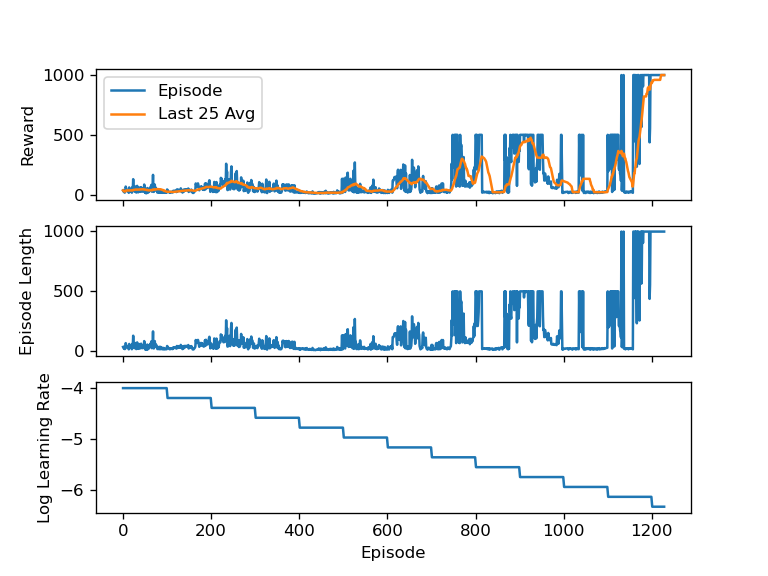

In [23]:
%matplotlib notebook
fig, ax = plt.subplots(3, sharex=True)
ax[0].plot(range(len(rewards)), rewards)
ax[0].plot(range(len(avg_rewards)), avg_rewards)
ax[0].set(ylabel='Reward')
ax[1].plot(range(len(episodeLengths)), episodeLengths)
ax[2].plot(range(len(learningRates)), np.log10(learningRates))
ax[1].set(ylabel='Episode Length')
ax[2].set(ylabel='Log Learning Rate')
ax[0].legend(["Episode", "Last 25 Avg"])
plt.xlabel('Episode')
plt.show()
plt.savefig('trainingInvertedDoublePendulum')

In [28]:
torch.save(agent.actor, 'singlePendulum-actor.pt')
torch.save(agent.critic, 'singlePendulum-critic.pt')
torch.save(agent1.actor, 'doublePendulum-actor.pt')
torch.save(agent1.actor, 'doublePendulum-critic.pt')

In [16]:
env = gym.make("InvertedPendulumBulletEnv-v0")
agent = DDPGagent(env)
agent.load_agent_networks('singlePendulum')
env.render()
states, actions, rewards, next_states, dones = [], [], [], [], []
collectedSamples = 0
while collectedSamples < 1e6:
    state = env.reset()
    done = False
    
    step = 0
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(np.array([action]))
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        dones.append(done)
        
        state = next_state
        step += 1
        collectedSamples += 1
    
    if step != 1000:
        print(step)
        
    if collectedSamples % 10000 == 0:
        print(collectedSamples)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000


In [28]:
env.close()

In [17]:
actions_array = np.array(actions)
states_array = np.array(states)
next_states_array = np.array(next_states)
rewards_array = np.array(rewards)
dones_array = np.array(dones)

In [18]:
np.save("invertedPendulumDataset/actions_array", actions_array)
np.save("invertedPendulumDataset/states_array", states_array)
np.save("invertedPendulumDataset/next_states_array", next_states_array)
np.save("invertedPendulumDataset/rewards_array", rewards_array)
np.save("invertedPendulumDataset/dones_array", dones_array)

In [23]:
print(b.shape)

(1000000, 5)
